## Image Preprocessing

This notebook uses DeepLab to create a binary mask and resizes the original image, and saves the two outputs locally 

Then, taking those two inputs, the model then excludes anything that isn't a person in the binary mask
and also removes the background

## DeepLab Implementation

In [1]:
#@title Imports

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
import cv2

#@title Helper methods


class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

def seg_mask(image, seg_map):

  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  return seg_image

def get_mask(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
    #original_im = Image.open(url)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  mask = seg_mask(resized_im, seg_map)
  return(mask)


def original_convert(url):
  """Resizes the original so mask and portrait image are the same size"""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im = MODEL.run(original_im)
  resized_good = np.asarray(resized_im[0])
  return(resized_good)


In [2]:
#@title Select and download models {display-mode: "form"}

MODEL_NAME = 'xception_coco_voctrainval'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [3]:
#choose an image using an image url to upload

IMAGE_URL = 'https://i.imgur.com/6XFgimb.png' 

image_url = IMAGE_URL 

In [4]:
y = get_mask(image_url)

running deeplab on image https://i.imgur.com/6XFgimb.png...


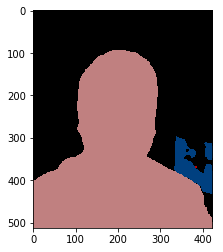

In [5]:
plt.imshow(y)

In [6]:
#choose a name for the portrait

name = "Jone_Cho"

In [7]:
#save the mask locally

cv2.imwrite('image2convert/' + name + '_mask.jpg', y)

True

In [8]:
x = original_convert(image_url)

running deeplab on image https://i.imgur.com/6XFgimb.png...


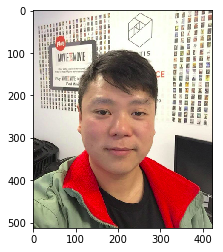

In [9]:
plt.imshow(x)

In [10]:
#save converted image locally

cv2.imwrite('image2convert/' + name + '_original.jpg', x)

True

## Edit Mask and Remove Background

In [12]:
#import mask and resized portrait

import numpy as np
import cv2
from matplotlib import pyplot as plt
img = cv2.imread('image2convert/' + name +'_original.jpg')
mask = cv2.imread('image2convert/' + name + '_mask.jpg')

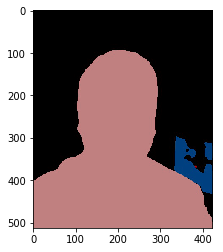

In [13]:
#as you can see below the computer screen was detected by DeepLAb
plt.imshow(mask)

In [14]:
#this code takes any pixel that isn't colored a person RGB(191,121,126) and turns it black (0,0,0) 

for i in range(0,len(mask)):
    for j in range(0,len(mask[0])):
        if np.any(mask[i][j][0] <= 180):
               mask[i][j] = [0,0,0]
        if np.any(mask[i][j][1] <= 110):
               mask[i][j] = [0,0,0]

In [15]:
#this code says for every pixel in the mask that is black, replace that pixel in the resized location with white
#this code only works because the mask and the resized image are the same dimensions

for i in range(0,len(mask)):
    for j in range(0,len(mask[0])):
        if np.any(mask[i][j][0] <= 170):
               img[i][j] = [255,255,255]

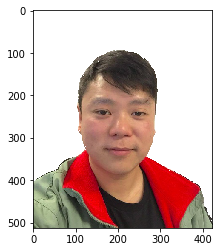

In [16]:
#background removed
plt.imshow(img)

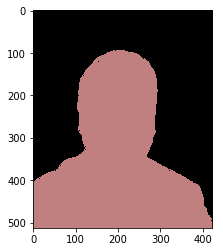

In [17]:
#non-people masks removed
plt.imshow(mask)

In [18]:
#save preprocessed image locally

cv2.imwrite('image_input/' + name + '_mask_edit.jpg', cv2.cvtColor(mask, cv2.COLOR_RGB2BGR))
cv2.imwrite('image_input/' + name + '_original_edit.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

True